<a href="https://colab.research.google.com/github/DARKINOO/Pytorch_practice/blob/main/cnn_fashion_mnist_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
#Set random seeds for reproducability
torch.manual_seed(42)

In [3]:
#Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [21]:
df = pd.read_csv('fashion-mnist_train.csv')

In [22]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
df.shape

(10417, 785)

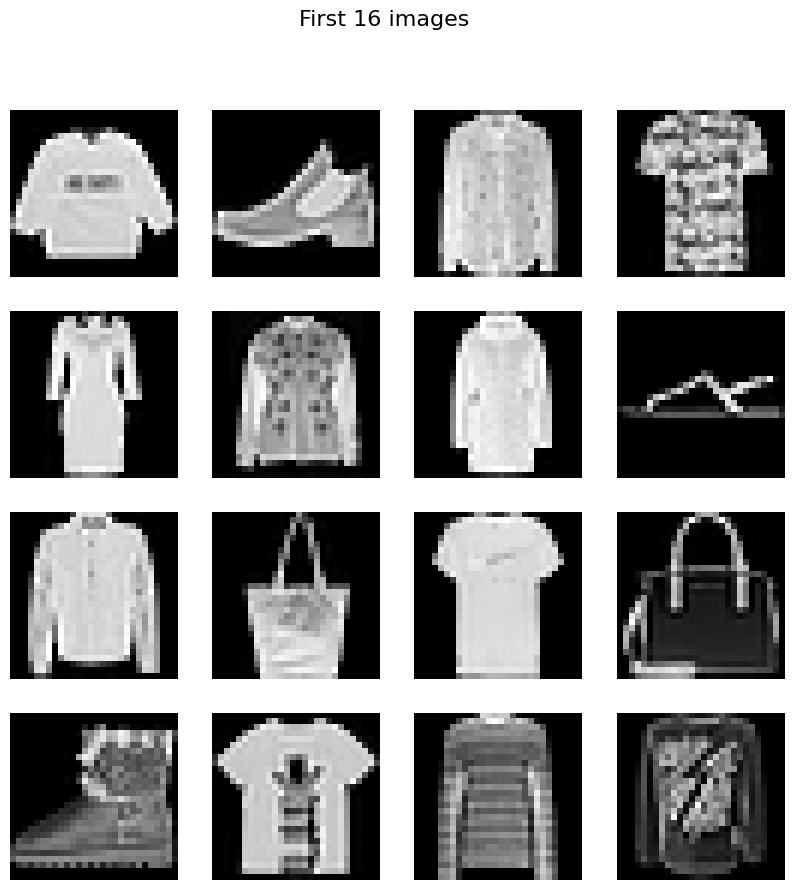

In [24]:
#Crate a 4x4 grid of images
fig, axes = plt.subplots(4,4,figsize=(10,10))
fig.suptitle("First 16 images", fontsize=16)

#plot the first 16 images from the dataset
for i, ax in enumerate(axes.flatten()):
    img = df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.show()

In [25]:
#train test split
X = df.iloc[:,1:].values
y = df.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [26]:
X_train = X_train/255.0
X_test = X_test/255.0

In [27]:
class CustomDataset(Dataset):

  def __init__(self,features,labels):

    #Convert to Pytorch tensors
    #reshape data into img input i.e batch size, channel, width and height
    self.features = torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    return self.features[idx],self.labels[idx]


In [28]:
train_dataset = CustomDataset(X_train,y_train)
test_dataset = CustomDataset(X_test,y_test)

In [29]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [30]:
class MyNN(nn.Module):

  def __init__(self, input_features):
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(input_features, 32, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding='same'),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p=0.4),

        nn.Linear(64,10)
    )


  def forward(self,x):
    x = self.features(x)
    x = self.classifier(x)

    return x

In [31]:
learning_rate = 0.01
epochs = 100

In [32]:

  model = MyNN(1)
  model.to(device)

  #optimizer selection
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)



In [33]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 1.1415064444487122
Epoch: 2 , Loss: 0.6445018939131522
Epoch: 3 , Loss: 0.5251410956926272
Epoch: 4 , Loss: 0.4593019333607392
Epoch: 5 , Loss: 0.4111320047542967
Epoch: 6 , Loss: 0.3715791666302188
Epoch: 7 , Loss: 0.3438027859076686
Epoch: 8 , Loss: 0.3120401646670711
Epoch: 9 , Loss: 0.27296790980173713
Epoch: 10 , Loss: 0.2546529571215312
Epoch: 11 , Loss: 0.2439926847872606
Epoch: 12 , Loss: 0.2261503852218732
Epoch: 13 , Loss: 0.20962534348169962
Epoch: 14 , Loss: 0.18398514284013673
Epoch: 15 , Loss: 0.17387468501268905
Epoch: 16 , Loss: 0.16000279294633774
Epoch: 17 , Loss: 0.1482453787899166
Epoch: 18 , Loss: 0.13746607518430184
Epoch: 19 , Loss: 0.13197006432203953
Epoch: 20 , Loss: 0.11280861713698712
Epoch: 21 , Loss: 0.10256073346996673
Epoch: 22 , Loss: 0.09112242752529139
Epoch: 23 , Loss: 0.09580601468839293
Epoch: 24 , Loss: 0.08811505676971541
Epoch: 25 , Loss: 0.08257811597523447
Epoch: 26 , Loss: 0.07498317617491258
Epoch: 27 , Loss: 0.0670683861681

In [34]:
 model.eval()


MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [35]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8857965451055663


In [36]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.999879995199808
